Данные:

X - пространственная координата оси x в пределах карты парка Монтесинью: от 1 до 9

Y - пространственная координата оси y в пределах карты парка Монтесинью: от 2 до 9

month - месяц года: от 'jan' до 'dec'

day - день недели: от 'mon' до 'sun'

FFMC - индекс FFMC из системы FWI: от 18,7 до 96,20

DMC - индекс DMC из системы FWI: от 1,1 до 291,3

DC - индекс DC из системы FWI: от 7,9 до 860,6

ISI - индекс ISI из системы FWI: от 0,0 до 56,10

temp - температура в градусах Цельсия: от 2,2 до 33,30

RH - относительная влажность в %: от 15,0 до 100

wind - скорость ветра в км/ч: от 0,40 до 9,40

rain - дождь на улице в мм/м2: от 0,0 до 6,4

area - площадь выгоревшего леса (в га): от 0,00 до 1090,84
(эта выходная переменная сильно смещена в сторону 0, поэтому может иметь смысл моделировать с помощью логарифмического преобразования).

In [311]:
!pip install opendatasets
!pip install bayesian-optimization

In [312]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [313]:
dataset_path = Path('forest-fires-data-set', 'forestfires.csv')

if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/elikplim/forest-fires-data-set')

df = pd.read_csv(dataset_path)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [314]:
# Проверка на пропущенные значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [315]:
# Проверка на выбросы
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [316]:
# Преобразуем категориальные признаки в числовые
df['month'] = pd.factorize(df['month'])[0]
df['day'] = pd.factorize(df['day'])[0]
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,0,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,1,1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,1,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,0,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,0,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


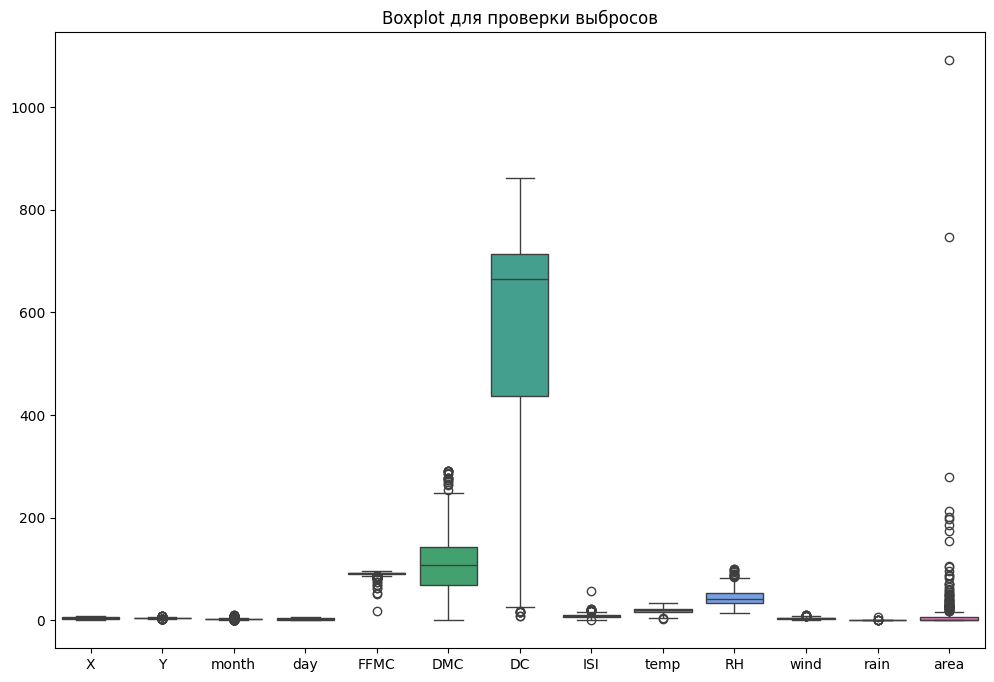

In [317]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.title('Boxplot для проверки выбросов')
plt.show()

In [318]:
# Применение логарифмического преобразования
df['area'] = np.log1p(df['area'])
# df['DMC'] = np.log1p(df['DMC'])
# df['DC'] = np.log1p(df['DC'])
# df['ISI'] = np.log1p(df['ISI'])

In [319]:
# Список столбцов с выбросами
columns_with_outliers = ['FFMC', 'DMC', 'DC', 'ISI', 'RH', 'area']

# Обработка выбросов для каждого столбца
for col in columns_with_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Убираем выбросы
    df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

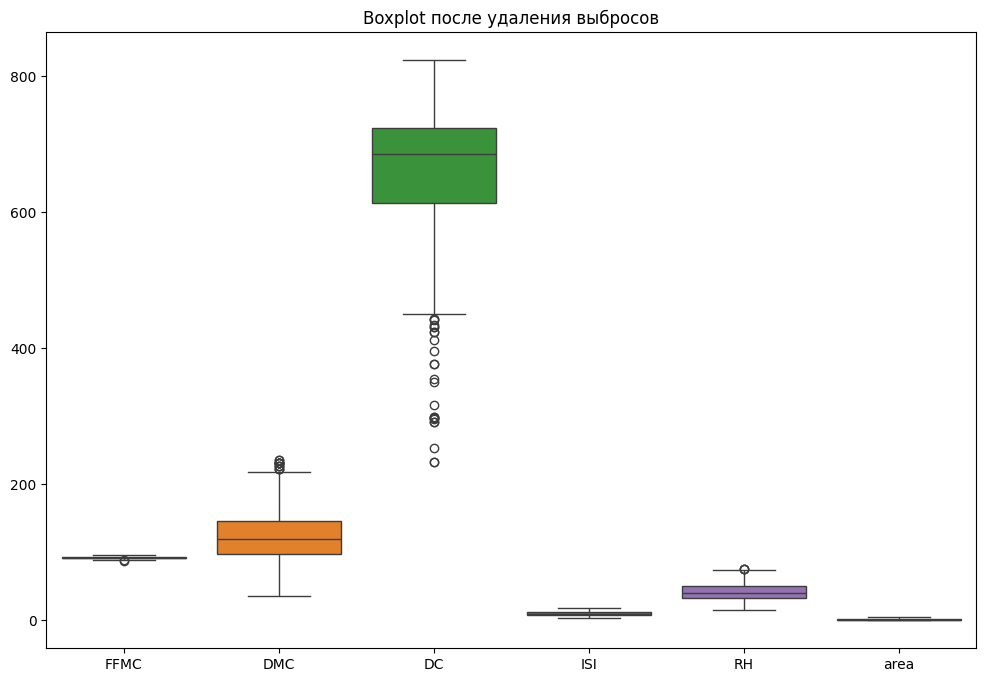

In [320]:
# Визуализация данных после удаления выбросов
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[columns_with_outliers])
plt.title('Boxplot после удаления выбросов')
plt.show()

In [321]:
df.shape

(350, 13)

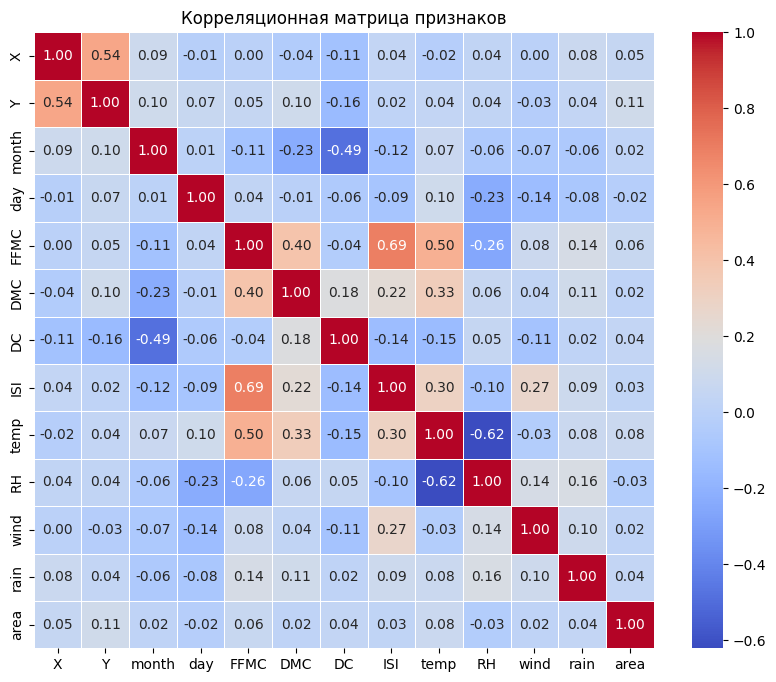

In [322]:
# Построение корреляционной матрицы
corr_matrix = df.corr()

# Визуализация с использованием heatmap
plt.figure(figsize=(10, 8))  # Размер изображения
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

plt.title('Корреляционная матрица признаков')
plt.show()

In [323]:
print(corr_matrix)

              X         Y     month       day      FFMC       DMC        DC  \
X      1.000000  0.537765  0.089915 -0.013696  0.004701 -0.042833 -0.113895   
Y      0.537765  1.000000  0.103148  0.065963  0.052782  0.104392 -0.155738   
month  0.089915  0.103148  1.000000  0.011722 -0.110086 -0.231685 -0.485349   
day   -0.013696  0.065963  0.011722  1.000000  0.035566 -0.005311 -0.057220   
FFMC   0.004701  0.052782 -0.110086  0.035566  1.000000  0.397363 -0.036334   
DMC   -0.042833  0.104392 -0.231685 -0.005311  0.397363  1.000000  0.181431   
DC    -0.113895 -0.155738 -0.485349 -0.057220 -0.036334  0.181431  1.000000   
ISI    0.042968  0.021604 -0.118174 -0.091981  0.689736  0.224411 -0.143960   
temp  -0.022185  0.041950  0.069293  0.103614  0.496050  0.328818 -0.148720   
RH     0.036909  0.036927 -0.060458 -0.229655 -0.259442  0.059960  0.050523   
wind   0.000725 -0.029038 -0.066338 -0.141214  0.082395  0.036817 -0.107455   
rain   0.079039  0.040302 -0.058908 -0.077993  0.141

In [324]:
# Разделяем данные на обучающую и тестовую
X = df.drop(columns=['X', 'Y', 'month', 'day', 'RH', 'wind', 'rain', 'area'])
y = df['area']

# Разбиваем на обучающую и тестовую выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация признаков
scaler = StandardScaler()

# Применяем стандартизацию к обучающим данным
X_train_scaled = scaler.fit_transform(X_train)

# Применяем стандартизацию к тестовым данным (используем fit из обучающей выборки)
X_test_scaled = scaler.transform(X_test)

# Проверим, как выглядят стандартизированные данные
print("Обучающие данные после стандартизации:")
print(X_train_scaled[:5])  # Печать первых 5 строк обучающих данных

print("\nТестовые данные после стандартизации:")
print(X_test_scaled[:5])  # Печать первых 5 строк тестовых данных

Обучающие данные после стандартизации:
[[-0.67717058  0.00356364  1.24013617 -0.44457962 -0.88084044]
 [-0.49296615  0.50366364 -0.41266781  0.23430249 -2.42358739]
 [-0.86137501  0.05357364  0.27901873 -0.90745378  0.2081574 ]
 [ 0.67366192  0.50366364  0.58731835 -0.56801273  2.09121617]
 [-1.59819274 -0.8156478   0.43714375 -1.58633589 -0.72202826]]

Тестовые данные после стандартизации:
[[-0.30876171  1.21094794  0.40445869  1.1909091   0.2081574 ]
 [ 2.33150181  1.35383365  0.14386159  1.34520049  0.14009504]
 [ 0.85786635  2.54454795  0.53166541 -0.47543789 -0.47246625]
 [-0.43156467 -0.37746494  0.96363823 -1.15432    -0.13215443]
 [-0.79997353  0.1250165   0.33290491 -0.90745378 -0.51784116]]


In [325]:
# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01))) # скрытый слой
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) # скрытый слой
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01))) # скрытый слой
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.01))) # выходной слой с линейной функцией активации

# Компиляция модели
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Обучение модели
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping],
                    verbose=1)  # Показывать процесс обучения

# Оценка модели на тестовой выборке
loss, mae, mse = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss (MSE): {loss}')
print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')

# Предсказания на тестовых данных
y_pred = model.predict(X_test_scaled)

# Пример: Можем вывести первые 5 предсказаний и реальные значения
print(f'Predictions: {y_pred[:5].flatten()}')
print(f'Actual values: {y_test[:5].values}')

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 4.2881 - mae: 1.1742 - mse: 2.9098 - val_loss: 3.4781 - val_mae: 0.9997 - val_mse: 2.1357
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.3468 - mae: 0.9339 - mse: 2.0145 - val_loss: 3.0034 - val_mae: 0.9593 - val_mse: 1.7014
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.9931 - mae: 0.9806 - mse: 1.7005 - val_loss: 2.7218 - val_mae: 0.9471 - val_mse: 1.4587
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0217 - mae: 1.0553 - mse: 1.7678 - val_loss: 2.5964 - val_mae: 0.9463 - val_mse: 1.3720
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0553 - mae: 1.1141 - mse: 1.8409 - val_loss: 2.5550 - val_mae: 0.9417 - val_mse: 1.3718
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8476 - mae: 1.0507 - mse: 1.6744 - val_loss: 2.5611 - val_mae: 0.9443 - val_mse: 1.4182
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7466 - mae: 1.0124 - mse: 1.6130 - val_loss: 2.5249 - val_m

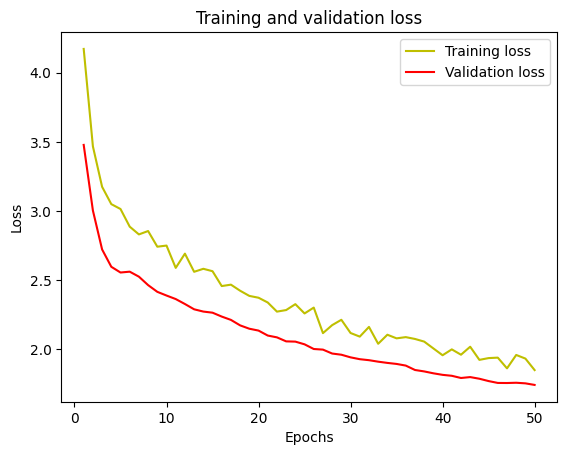

In [326]:
# Получаем значения потерь для обучения и валидации
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Строим график
plt.plot(epochs, loss, 'y', label='Training loss')  # Потери на обучающей выборке (горчичный)
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # Потери на валидационной выборке (красный)

# Добавляем заголовок и подписи
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()

In [327]:
# Предсказания модели на тестовых данных
y_pred = model.predict(X_test_scaled)

# Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Средняя квадратичная ошибка (MSE)
mse = mean_squared_error(y_test, y_pred)

# Корень из средней квадратичной ошибки (RMSE)
rmse = np.sqrt(mse)

# Коэффициент детерминации (R²)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error (MAE): 0.9458851994428816
Mean Squared Error (MSE): 1.3859438934353878
Root Mean Squared Error (RMSE): 1.1772611831855273
R² Score: -0.0206721095418807
